In [2]:
#SETUP AND DATA LOADING
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
# Download necessary NLTK data
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Load the dataset
df = pd.read_csv('spam_ham_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
df.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [6]:
# PREPROCESSING AND CLEANING
df = df.drop('Unnamed: 0', axis=1)

In [7]:
# Convert text labels to numerical format (spam=1, ham=0)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nLabels converted to numerical format (spam=1, ham=0).")


Labels converted to numerical format (spam=1, ham=0).


In [11]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Function to clean the raw text data.
    - Removes non-alphabetic characters
    - Converts to lowercase
    - Removes stop words
    - Lemmatizes words
    """
# Remove non-alphabetic characters and convert to lower case
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    words = text.split()

    # Remove stop words and perform lemmatization
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(cleaned_words)

In [12]:
# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)
print("Text cleaning and lemmatization complete.")
print("\n--- Data after Cleaning ---")
print(df.head())

Text cleaning and lemmatization complete.

--- Data after Cleaning ---
   label                                               text  label_num  \
0      0  Subject: enron methanol ; meter # : 988291\r\n...          0   
1      0  Subject: hpl nom for january 9 , 2001\r\n( see...          0   
2      0  Subject: neon retreat\r\nho ho ho , we ' re ar...          0   
3      1  Subject: photoshop , windows , office . cheap ...          1   
4      0  Subject: re : indian springs\r\nthis deal is t...          0   

                                        cleaned_text  
0  subject enron methanol meter follow note gave ...  
1  subject hpl nom january see attached file hpln...  
2  subject neon retreat ho ho ho around wonderful...  
3  subject photoshop window office cheap main tre...  
4  subject indian spring deal book teco pvr reven...  



--- Generating Data Visualizations ---


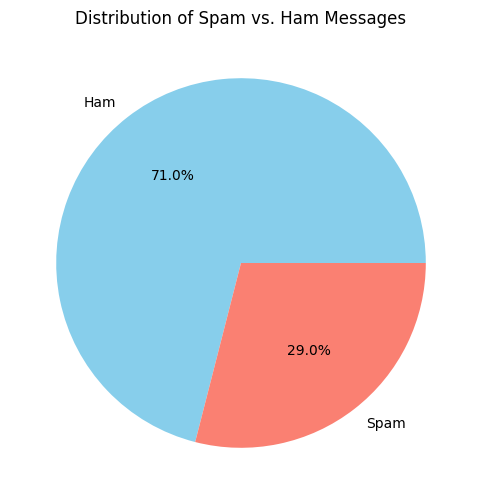

In [13]:
# DATA VISUALIZATION
print("\n--- Generating Data Visualizations ---")

# Class Distribution (Spam vs. Ham)
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Ham', 'Spam'], colors=['skyblue', 'salmon'])
plt.title('Distribution of Spam vs. Ham Messages')
plt.ylabel('')
plt.show()

In [14]:
# Word Clouds for Spam and Ham
ham_text = " ".join(df[df['label'] == 0]['cleaned_text'])
spam_text = " ".join(df[df['label'] == 1]['cleaned_text'])

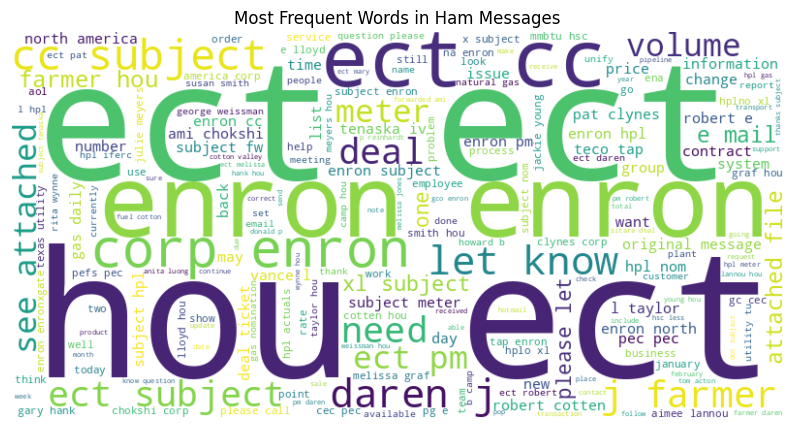

In [15]:
# Ham Word Cloud
plt.figure(figsize=(10, 7))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Most Frequent Words in Ham Messages')
plt.axis('off')
plt.show()

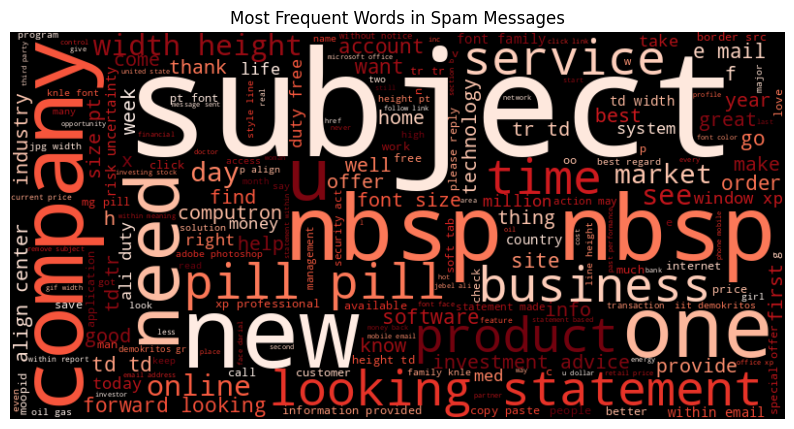

In [16]:
# Spam Word Cloud
plt.figure(figsize=(10, 7))
wordcloud_spam = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Most Frequent Words in Spam Messages')
plt.axis('off')
plt.show()

In [17]:
# FEATURE ENGINEERING (TF-IDF)
print("\n--- Performing Feature Engineering with TF-IDF ---")

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# Fit and transform the cleaned text data
X = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['label']

print(f"Data has been converted into a TF-IDF matrix of shape: {X.shape}")


--- Performing Feature Engineering with TF-IDF ---
Data has been converted into a TF-IDF matrix of shape: (5171, 3000)


In [18]:
# MODEL TRAINING
print("\nSplitting Data and Training Models")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


--- Splitting Data and Training Models ---
Training set size: 4136, Test set size: 1035


In [19]:
# Initialize the models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [20]:
# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
print("All models trained successfully.")

Training Naive Bayes...
Training SVM...
Training Decision Tree...
All models trained successfully.



--- Evaluating Models ---

----- Evaluating: Naive Bayes -----
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.95      0.96       735
        Spam       0.88      0.95      0.91       300

    accuracy                           0.95      1035
   macro avg       0.93      0.95      0.94      1035
weighted avg       0.95      0.95      0.95      1035



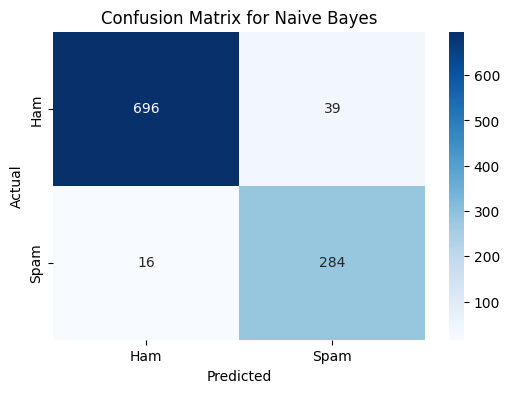


----- Evaluating: SVM -----
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       735
        Spam       0.95      0.97      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



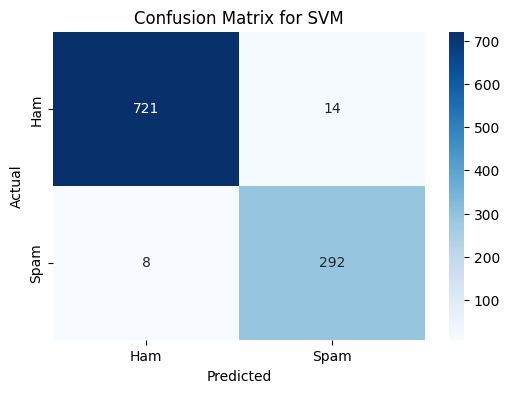


----- Evaluating: Decision Tree -----
Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.96      0.97       735
        Spam       0.91      0.93      0.92       300

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



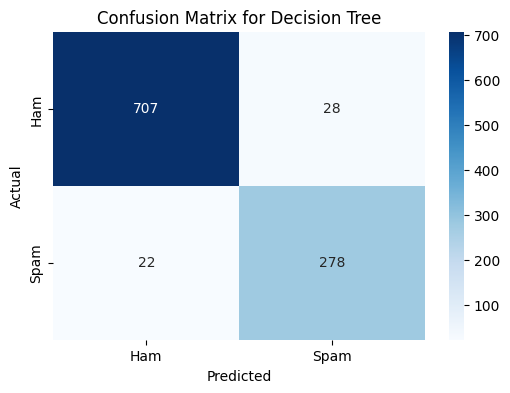

In [21]:
# 6. MODEL EVALUATION AND COMPARISON
print("\n--- Evaluating Models ---")
results = {}

for name, model in models.items():
    print(f"\n----- Evaluating: {name} -----")

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


--- Final Model Comparison ---
               Accuracy  Precision    Recall  F1-Score
Naive Bayes    0.946860   0.879257  0.946667  0.911717
SVM            0.978744   0.954248  0.973333  0.963696
Decision Tree  0.951691   0.908497  0.926667  0.917492


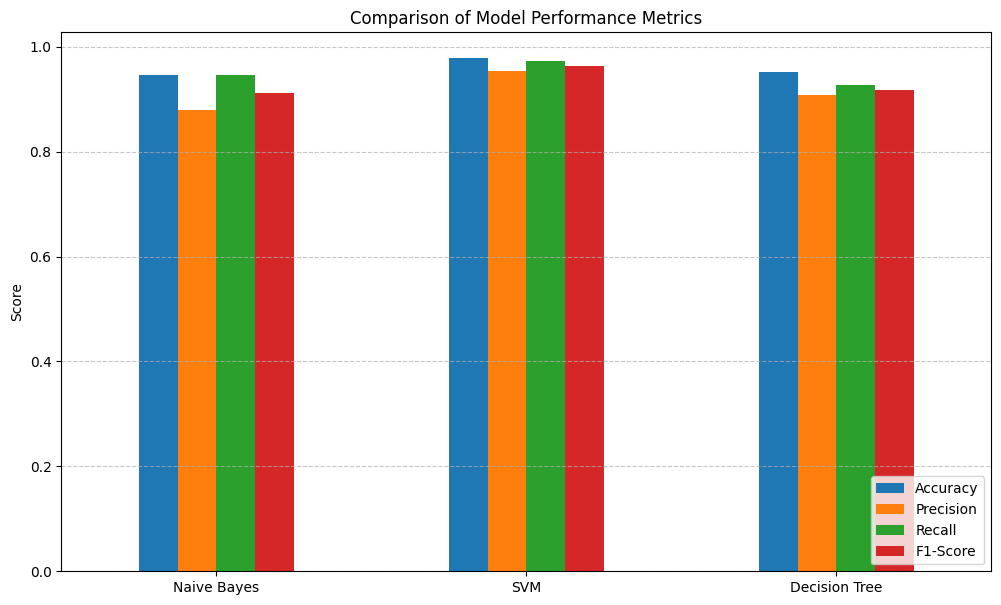


Project complete. Naive Bayes typically performs best for this task due to its effectiveness with text data and handling of high-dimensional feature spaces from TF-IDF.


In [22]:
# FINAL RESULTS COMPARISON
print("\n Final Model Comparison ")

# Create a DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print(results_df)

# Plotting the comparison
results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nProject complete. Naive Bayes typically performs best for this task due to its effectiveness with text data and handling of high-dimensional feature spaces from TF-IDF.")

In [25]:
# 8. PREDICTION ON NEW MESSAGES
print("\n Testing Models with New, Unseen Messages")

# Create a function to handle the full prediction pipeline
def predict_message(message, model, vectorizer):
    """
    Takes a raw text message and predicts if it's spam or ham.
    - message: string, the input message.
    - model: a trained scikit-learn classifier.
    - vectorizer: the fitted TfidfVectorizer.
    """
    # Clean the new message using the same function
    cleaned_message = clean_text(message)

    # Transform the cleaned message into a TF-IDF vector
    message_tfidf = vectorizer.transform([cleaned_message])

    # 3. Make the prediction
    if isinstance(model, SVC) or isinstance(model, DecisionTreeClassifier):
        message_tfidf = message_tfidf.toarray()

    prediction_code = model.predict(message_tfidf)[0]

    # 4. Return the human-readable label
    return "Spam" if prediction_code == 1 else "Ham"

#Example Messages to Test
new_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/xyz to claim now.",
    "Hey, are we still on for lunch tomorrow at 1 PM? Let me know.",
    "URGENT: Your account has been suspended. Please verify your payment details immediately to avoid closure.",
    "Thanks for your order. Your package will be delivered by Tuesday."
]

# Classify Each Message Using All Trained Models
for message in new_messages:
    print(f"\nOriginal Message: \"{message}\"")
    for name, model in models.items():
        prediction = predict_message(message, model, tfidf_vectorizer)
        print(f"  -> Prediction ({name}): {prediction}")


 Testing Models with New, Unseen Messages

Original Message: "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/xyz to claim now."
  -> Prediction (Naive Bayes): Spam
  -> Prediction (SVM): Spam
  -> Prediction (Decision Tree): Spam

Original Message: "Hey, are we still on for lunch tomorrow at 1 PM? Let me know."
  -> Prediction (Naive Bayes): Ham
  -> Prediction (SVM): Ham
  -> Prediction (Decision Tree): Ham

Original Message: "URGENT: Your account has been suspended. Please verify your payment details immediately to avoid closure."
  -> Prediction (Naive Bayes): Spam
  -> Prediction (SVM): Spam
  -> Prediction (Decision Tree): Ham

Original Message: "Thanks for your order. Your package will be delivered by Tuesday."
  -> Prediction (Naive Bayes): Ham
  -> Prediction (SVM): Ham
  -> Prediction (Decision Tree): Spam
